In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

from wordcloud import WordCloud

import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
from gensim.models import CoherenceModel, LdaMulticore
from gensim.corpora import Dictionary

In [4]:
bad_reviews = pd.read_csv('data/bad_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

In [5]:
good_reviews = pd.read_csv('data/good_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

In [6]:
sample_reviews = pd.read_csv('data/sample_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

## Corpus

In [7]:
corpus_bad    = ". ".join(list(bad_reviews.text))
corpus_good   = ". ".join(list(good_reviews.text))
corpus_sample = ". ".join(list(sample_reviews.text))

## Cleaning function

In [8]:
def process_text(doc,
                 stop_words,
                 rejoin=False,
                 lem_or_stem="stem",
                 rare_words=None,
                 min_len_word=3,
                 force_is_alpha=True,
                 context=None,
                 english_words=None):
    """Process a text with selection of english words
    positionnal args :
    -------------------
    doc: str: the document to process
    
    optional args :
    ----------------
    rejoin: bool: if False return a list of words, else return the string of joined element of the list
    lem_or_stem : choice between lemmatize and stemmatize
    rare_words: list : list of rare words to exclude
    force_is_alpha: int: if 1 exclude all tokens with a numeric character
    english_words: list: list of english words accepted
    
    return:
    --------
    List of tokens if rejoin=False, the joined list if True.
    """
    if not rare_words:
        rare_words=[]
    
    doc = doc.lower().strip()
    
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    
    cleaned_tokens_list = [word for word in raw_tokens_list if word not in stop_words]
    
    non_rare_tokens = [word for word in cleaned_tokens_list if word not in rare_words]
    
    large_words = [word for word in non_rare_tokens if len(word) >= min_len_word]
    
    if force_is_alpha:
        alpha_tokens = [word for word in large_words if word.isalpha()]
    else:
        alpha_tokens = large_words
        
    if lem_or_stem == "lem":
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else:
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
        
    if context:
        new_text = [word for word in trans_text if word not in context]
    else:
        new_text = trans_text
        
    if english_words:
        english_text = [i for i in new_text if i in english_words]
    else:
        english_text = new_text
        
    if rejoin:
        return " ".join(english_text)
    else:
        return english_text

In [9]:
def display_tokens_info(tokens):
    """Display info about corpus"""
    print(f"Nb tokens : {len(tokens)}")
    print(f"Nb tokens uniques : {len(set(tokens))}")
    print(tokens[:30])

## Process corpus

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
corpus_bad_1 = process_text(corpus_bad, stop_words=stop_words,)

display_tokens_info(corpus_bad_1)

Nb tokens : 365805
Nb tokens uniques : 11581
['brisket', 'pretti', 'good', 'rib', 'pork', 'call', 'carolina', 'pork', 'groser', 'misrepresent', 'even', 'close', 'might', 'want', 'two', 'counter', 'guy', 'outsid', 'build', 'look', 'nice', 'new', 'stop', 'coupon', 'book', 'get', 'free', 'ice', 'coffe', 'purchas']


In [12]:
corpus_good_1 = process_text(corpus_good, stop_words=stop_words,)

display_tokens_info(corpus_good_1)

Nb tokens : 298030
Nb tokens uniques : 11320
['food', 'phenomen', 'servic', 'friendli', 'price', 'reason', 'lean', 'person', 'work', 'counter', 'advic', 'pad', 'kra', 'pow', 'basil', 'chicken', 'ask', 'made', 'hot', 'deliv', 'issu', 'get', 'suffici', 'spici', 'food', 'around', 'town', 'pleasant', 'surpris', 'spice']


In [13]:
corpus_sample_1 = process_text(corpus_sample, stop_words=stop_words,)

display_tokens_info(corpus_sample_1)

Nb tokens : 1072250
Nb tokens uniques : 21545
['brisket', 'pretti', 'good', 'rib', 'pork', 'call', 'carolina', 'pork', 'groser', 'misrepresent', 'even', 'close', 'might', 'want', 'two', 'counter', 'guy', 'outsid', 'build', 'look', 'nice', 'new', 'stop', 'coupon', 'book', 'get', 'free', 'ice', 'coffe', 'purchas']


## Rare words

In [14]:
tmp = pd.Series(corpus_sample_1).value_counts()

In [15]:
tmp

food           15981
order          12708
place          12021
good           11775
time            8762
               ...  
soondobu           1
givem              1
chickenless        1
eyebrow            1
charvida           1
Length: 21545, dtype: int64

In [16]:
unique_words = tmp[tmp==1]

In [17]:
len(unique_words)

8948

In [18]:
unique_words = list(unique_words.index)

In [19]:
less_5_words = list(tmp[tmp<5].index)

In [20]:
len(less_5_words)

14200

In [21]:
less_10_words = list(tmp[tmp<10].index)

In [22]:
len(less_10_words)

16516

In [23]:
corpus_bad_2 = process_text(corpus_bad,
                            stop_words=stop_words,
                            rare_words=less_5_words)

In [24]:
corpus_good_2 = process_text(corpus_good,
                             stop_words=stop_words,
                             rare_words=less_5_words)

In [25]:
corpus_sample_2 = process_text(corpus_sample,
                               stop_words=stop_words,
                               rare_words=less_5_words)

In [26]:
display_tokens_info(corpus_bad_2)

Nb tokens : 357197
Nb tokens uniques : 8934
['brisket', 'pretti', 'good', 'rib', 'pork', 'call', 'carolina', 'pork', 'misrepresent', 'even', 'close', 'might', 'want', 'two', 'counter', 'guy', 'outsid', 'build', 'look', 'nice', 'new', 'stop', 'coupon', 'book', 'get', 'free', 'ice', 'coffe', 'purchas', 'clearli']


In [27]:
display_tokens_info(corpus_good_2)

Nb tokens : 289335
Nb tokens uniques : 8304
['food', 'phenomen', 'servic', 'friendli', 'price', 'reason', 'lean', 'person', 'work', 'counter', 'advic', 'pad', 'basil', 'chicken', 'ask', 'made', 'hot', 'deliv', 'issu', 'get', 'suffici', 'food', 'around', 'town', 'pleasant', 'surpris', 'spice', 'prefer', 'also', 'egg']


In [28]:
display_tokens_info(corpus_sample_2)

Nb tokens : 1041111
Nb tokens uniques : 13635
['brisket', 'pretti', 'good', 'rib', 'pork', 'call', 'carolina', 'pork', 'misrepresent', 'even', 'close', 'might', 'want', 'two', 'counter', 'guy', 'outsid', 'build', 'look', 'nice', 'new', 'stop', 'coupon', 'book', 'get', 'free', 'ice', 'coffe', 'purchas', 'clearli']


**Save**

Les traitements étant longs, on sauvegarde les corpus.

In [29]:
with open("results/corpus_bad", "wb") as fp:
    pickle.dump(corpus_bad_2, fp)
    
with open("results/corpus_good", "wb") as fp:
    pickle.dump(corpus_good_2, fp)
    
with open("results/corpus_sample", "wb") as fp:
    pickle.dump(corpus_sample_2, fp)

## First WordCloud

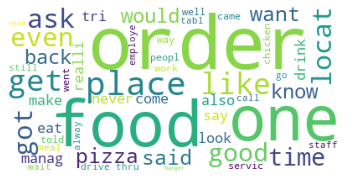

In [30]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_bad_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

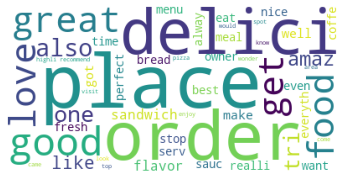

In [31]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_good_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

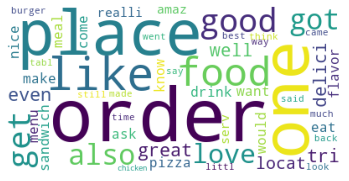

In [32]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_sample_2))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

On voit que beaucoup de mots sont communs aux différents nuages de mots : order, food, one, ...  
Construisons des mots de contexte pour que ces mots soient filtrés.

### Context

In [33]:
pd.Series(corpus_bad_2).value_counts().head(20)

order      6908
food       5982
time       4020
get        3560
place      3333
one        3105
like       3093
servic     2739
good       2585
wait       2473
back       2176
would      2082
minut      2052
got        1955
ask        1938
even       1877
locat      1836
pizza      1781
chicken    1622
want       1508
dtype: int64

In [34]:
pd.Series(corpus_good_2).value_counts().head(20)

food        4651
place       4054
great       3506
good        2844
tri         2597
delici      2560
order       2130
love        2123
back        1935
best        1930
time        1926
amaz        1914
one         1752
get         1728
like        1663
also        1635
sandwich    1630
fresh       1611
friendli    1603
servic      1591
dtype: int64

In [35]:
n = 20
doublons = [i for i in pd.Series(corpus_bad_2).value_counts().head(n).index
            if i in pd.Series(corpus_good_2).value_counts().head(n).index]
doublons

['order',
 'food',
 'time',
 'get',
 'place',
 'one',
 'like',
 'servic',
 'good',
 'back']

In [36]:
pd.Series(corpus_sample_2).value_counts().head(20)

food       15981
order      12708
place      12021
good       11775
time        8762
great       8457
get         7966
like        7943
one         7208
servic      6997
tri         6324
back        6208
would       5180
realli      5106
got         4668
also        4621
wait        4590
love        4517
delici      4460
chicken     4337
dtype: int64

In [37]:
context = doublons

In [38]:
corpus_bad_3 = process_text(corpus_bad,
                            stop_words=stop_words,
                            rare_words=less_5_words,
                            context=context)

In [39]:
corpus_good_3 = process_text(corpus_good,
                             stop_words=stop_words,
                             rare_words=less_5_words,
                             context=context)

In [40]:
corpus_sample_3 = process_text(corpus_sample,
                               stop_words=stop_words,
                               rare_words=less_5_words,
                               context=context)

In [41]:
with open("results/corpus_bad_context", "wb") as fp:
    pickle.dump(corpus_bad_3, fp)
    
with open("results/corpus_good_context", "wb") as fp:
    pickle.dump(corpus_good_3, fp)
    
with open("results/corpus_sample_context", "wb") as fp:
    pickle.dump(corpus_sample_3, fp)

In [42]:
display_tokens_info(corpus_bad_2)

Nb tokens : 357197
Nb tokens uniques : 8934
['brisket', 'pretti', 'good', 'rib', 'pork', 'call', 'carolina', 'pork', 'misrepresent', 'even', 'close', 'might', 'want', 'two', 'counter', 'guy', 'outsid', 'build', 'look', 'nice', 'new', 'stop', 'coupon', 'book', 'get', 'free', 'ice', 'coffe', 'purchas', 'clearli']


In [43]:
display_tokens_info(corpus_good_2)

Nb tokens : 289335
Nb tokens uniques : 8304
['food', 'phenomen', 'servic', 'friendli', 'price', 'reason', 'lean', 'person', 'work', 'counter', 'advic', 'pad', 'basil', 'chicken', 'ask', 'made', 'hot', 'deliv', 'issu', 'get', 'suffici', 'food', 'around', 'town', 'pleasant', 'surpris', 'spice', 'prefer', 'also', 'egg']


In [44]:
display_tokens_info(corpus_sample_2)

Nb tokens : 1041111
Nb tokens uniques : 13635
['brisket', 'pretti', 'good', 'rib', 'pork', 'call', 'carolina', 'pork', 'misrepresent', 'even', 'close', 'might', 'want', 'two', 'counter', 'guy', 'outsid', 'build', 'look', 'nice', 'new', 'stop', 'coupon', 'book', 'get', 'free', 'ice', 'coffe', 'purchas', 'clearli']


## Second WordCloud

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

from wordcloud import WordCloud

import pickle

In [46]:
import gensim
from gensim.models import TfidfModel

import pyLDAvis
import pyLDAvis.gensim_models 

In [47]:
with open("results/corpus_bad", "rb") as fp:
    corpus_bad_3 = pickle.load(fp)

In [48]:
with open("results/corpus_good", "rb") as fp:
    corpus_good_3 = pickle.load(fp)

In [49]:
with open("results/corpus_sample", "rb") as fp:
    corpus_sample_3 = pickle.load(fp)

In [50]:
with open("results/filtered_words", "rb") as fp:
    filtered_words = pickle.load(fp)

In [95]:
import warnings
warnings.filterwarnings('ignore')

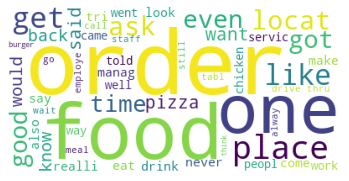

In [96]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_bad_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

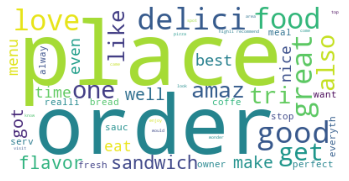

In [97]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_good_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

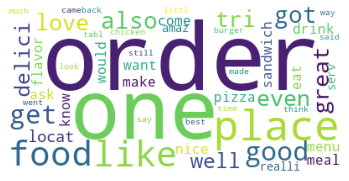

In [98]:
wordcloud = WordCloud(background_color='white',
                      stopwords=[],
                      max_words=50).generate(" ".join(corpus_sample_3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

# 2. Sujet d'insatisfaction avec LDA

In [54]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [55]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [56]:
bad_reviews = pd.read_csv('data/bad_reviews',
                          dtype={
                                 "review_id": str,
                                 "user_id": str,
                                 "business_id": str,
                                 "stars": 'uint8',
                                 "useful": 'int16',
                                 "funny": 'int16',
                                 "cool": 'int16',
                                 "text": str,
                                } 
                         )

In [57]:
filtered_words.append('would')

In [58]:
bad_reviews_corpus = [process_text(review, stop_words=filtered_words) for review in bad_reviews.text]

In [59]:
pyLDAvis.enable_notebook()

## 2.1. Choix du nombre de topics

In [60]:
with open("results/coherence", "rb") as fp:
    coherence_df = pickle.load(fp)

In [61]:
bigram = gensim.models.Phrases(bad_reviews_corpus, min_count=2, threshold=60) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[bad_reviews_corpus],threshold=60)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(all_doc):
    return [bigram_mod[doc] for doc in all_doc]

def make_trigrams(all_doc):
    return [trigram_mod[doc] for doc in all_doc]

In [62]:
data_clean_bigram = make_bigrams(bad_reviews_corpus)
data_clean_trigram = make_trigrams(bad_reviews_corpus)

In [63]:
id2word = Dictionary(data_clean_trigram)
texts = data_clean_trigram
corpus = [id2word.doc2bow(text) for text in texts]

In [64]:
model = TfidfModel(corpus)
corpus_tfidf = model[corpus]

In [ ]:
# %%time

# coherences = dict()

# for k in range(3, 20):
#     print('Number of Topics: ' + str(k))
#     ldamodel = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=40, iterations=20, chunksize=10000, eval_every=None, workers=30)
#     cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts, dictionary=id2word, coherence='c_v')
    
    
#     print(f"Coherence : {cm.get_coherence()}")
#     print("Coherence max :", coherence_max )
    
    
#     if cm.get_coherence() > coherence_max:
#         coherence_max = cm.get_coherence()
#         print("Model save \n")
#         ldamodel.save('results/lda.model')
#     coherences[k] = [cm.get_coherence()]

In [68]:
# for i in range(10):
#     print(f"\n Loop {i} \n")
#     coherences = dict()

#     for k in range(3, 20):
#         print('Number of Topics: ' + str(k))
#         ldamodel = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=40, iterations=20, chunksize=10000, eval_every=None, workers=30)
#         cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=texts, dictionary=id2word, coherence='c_v')


#         print(f"Coherence : {cm.get_coherence()}")
#         print("Coherence max :", coherence_max )


#         if cm.get_coherence() > coherence_max:
#             coherence_max = cm.get_coherence()
#             print("Model save \n")
#             ldamodel.save('results/lda.model')
#         coherences[k] = [cm.get_coherence()]
        
#     coherence_df = pd.concat([coherence_df, pd.DataFrame(coherences)], ignore_index=True)

In [79]:
with open("results/coherence", "wb") as fp:
    pickle.dump(coherence_df, fp)

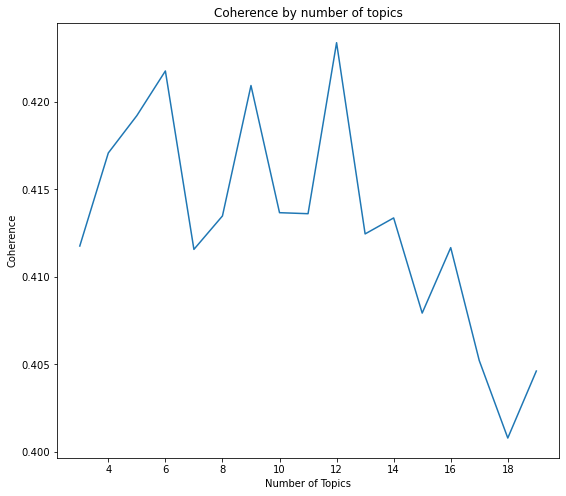

In [80]:
plt.figure(figsize=(9,8))
plt.plot(coherence_df.mean(axis=0))
plt.title('Coherence by number of topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.show()

## 2.2. Modélisation

In [91]:
with open("results/lda_texts", "wb") as fp:
    pickle.dump(texts, fp)

In [92]:
with open("results/lda_id2word", "wb") as fp:
    pickle.dump(id2word, fp)

In [94]:
with open("results/lda_corpus", "wb") as fp:
    pickle.dump(corpus, fp)

## Best model : 5 topics

In [81]:
from gensim import models

In [82]:
lda_best_model =  models.LdaModel.load('results/lda.model')
lda_best_model.num_topics

5

In [83]:
cm = CoherenceModel(model=lda_best_model, texts=texts, dictionary=id2word, coherence='c_v')
cm.get_coherence()

0.4567538530000631

In [84]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models .prepare(lda_best_model, corpus, id2word)
p

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.071337  0.019565       1        1  24.498346
1      0.130182  0.109978       2        1  23.506137
0     -0.039605 -0.070361       3        1  20.279194
2      0.101009 -0.103159       4        1  19.981907
4     -0.120249  0.043977       5        1  11.734416, topic_info=        Term         Freq        Total Category  logprob  loglift
374    pizza  1574.000000  1574.000000  Default  30.0000  30.0000
1       call  1000.000000  1000.000000  Default  29.0000  29.0000
93      tabl  1089.000000  1089.000000  Default  28.0000  28.0000
181  chicken  1535.000000  1535.000000  Default  27.0000  27.0000
196    minut  1914.000000  1914.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
351      got   171.651013  1899.436778   Topic5  -5.3764  -0.2612
94      take   156.317441  1116.843052   Topic5  -5.4699   0.1763
341   custom   154.368065  1174.940065   Topic5  -5.4825   0.1130
496     give   152.014887  1132.309203   Topic5  -5.4978   0.1346
171     wait   150.949545  2402.913272   Topic5  -5.5049  -0.6248

[426 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1457      2  0.254175    airport
1457      3  0.012924    airport
1457      4  0.732370    airport
4563      3  0.924695      alarm
3175      1  0.951230     allerg
...     ...       ...        ...
1041      4  0.014759      wrong
1041      5  0.147588      wrong
398       1  0.937353        wth
2922      1  0.975245  young_man
2922      3  0.027090  young_man

[1021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

1. Delay
2. Bad order, Taste
3. Staff pb
4. Service
5. Pizza commands

## Performant model with 9 topics

In [85]:
lda_model_9 =  models.LdaModel.load('results/9_topics/lda.model')
lda_model_9.num_topics

9

In [86]:
cm = CoherenceModel(model=lda_model_9, texts=texts, dictionary=id2word, coherence='c_v')
cm.get_coherence()

0.44162166676202946

In [87]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models .prepare(lda_model_9, corpus, id2word)
p

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.028657  0.052996       1        1  12.986141
8      0.079655 -0.068863       2        1  12.789678
6      0.095202  0.087529       3        1  11.893227
7      0.142080 -0.007130       4        1  11.311078
1     -0.127957  0.028397       5        1  10.821952
4     -0.138224 -0.027806       6        1  10.324206
0     -0.099815  0.140760       7        1  10.134133
5      0.104751 -0.036379       8        1  10.126555
3     -0.084349 -0.169505       9        1   9.613030, topic_info=        Term         Freq        Total Category  logprob  loglift
374    pizza  1594.000000  1594.000000  Default  30.0000  30.0000
181  chicken  1517.000000  1517.000000  Default  29.0000  29.0000
171     wait  2409.000000  2409.000000  Default  28.0000  28.0000
274   burger   829.000000   829.000000  Default  27.0000  27.0000
1       call  1013.000000  1013.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
132     need   112.813934   991.313150   Topic9  -5.5967   0.1688
449      see   103.895468   712.800734   Topic9  -5.6790   0.4162
248   expect   103.057674   678.751075   Topic9  -5.6871   0.4571
141   servic   114.587836  2656.870650   Topic9  -5.5811  -0.8015
5       even   108.403289  1828.377559   Topic9  -5.6366  -0.4833

[730 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5760      3  0.950392       accus
1893      1  0.030204  acknowledg
1893      2  0.583937  acknowledg
1893      4  0.281901  acknowledg
1893      5  0.010068  acknowledg
...     ...       ...         ...
4002      3  0.064805         yum
4002      5  0.907263         yum
2185      3  0.194533   zero_star
2185      8  0.756519   zero_star
2185      9  0.021615   zero_star

[2315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 7, 8, 2, 5, 1, 6, 4])

1. Command error
2. Service
3. Pizza commands
4. Delay
5. Fast food
6. Price vs quality
7. Command error
8. Polite
9. Area handling